In [1]:
import numpy as np
import pandas as pd

import os
import glob
import librosa
import tqdm
import pickle
import time

from collections import Counter, defaultdict

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import lr_scheduler
from torch import nn
import torch.nn.functional as F
import torch

from skmultilearn.model_selection import iterative_train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import utils
from flame import Trainer

sns.set()

DATA_PATH = './data'
join_path = lambda path: os.path.join(DATA_PATH, path)

In [2]:
with open(join_path('train_raw.pkl'), 'rb+') as f:
    train_X = pickle.load(f)
    
with open(join_path('val_raw.pkl'), 'rb+') as f:
    val_X = pickle.load(f)
    
train_y = np.load(join_path('train_targets.npy'))
val_y = np.load(join_path('val_targets.npy'))

In [3]:
train_ds = TensorDataset(torch.FloatTensor(train_X).unsqueeze(1).contiguous(), torch.FloatTensor(train_y))
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = TensorDataset(torch.FloatTensor(val_X).unsqueeze(1).contiguous(), torch.FloatTensor(val_y))
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

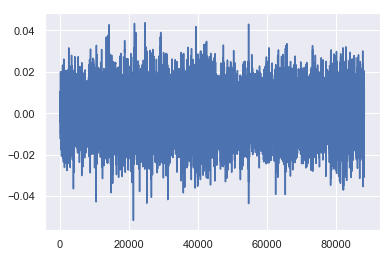

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_X[9])

In [5]:
# Raw Waveform-based Audio Classification Using Sample-level CNN Architectures
# https://arxiv.org/pdf/1712.00866.pdf

ConvBlock = lambda in_channels, out_channels: nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3),
)

class Dropout1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        return self.dropout(x.unsqueeze(-1)).squeeze(-1)

class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.process = nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(channels),
            nn.ReLU(),
            Dropout1d(),
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(channels)            
        )
        
        self.gate = nn.Sequential(
            nn.Linear(channels, 2 * channels),
            nn.ReLU(),
            nn.Linear(2 * channels, channels),
            nn.Sigmoid()
        )
        
        self.postprocess = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3)
        )
        
    def forward(self, x):
        y = self.process(x)
        g = self.gate(x.mean(dim=-1))
        return self.postprocess(x + y * g[:, :, None])

class ReSE_2_Multi(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convs = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, stride=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
        )
        
        self.levels = 3
        self.head = nn.Linear(64 * self.levels, 80)
        
    def forward(self, x):
        x = self.convs[:-self.levels](x)
        
        last_features = []
        for module in self.convs[-self.levels:]:
            x = module(x)
            last_features.append(torch.max(x, dim=-1)[0])
            
        features = torch.cat(last_features, dim=1)
        
        return self.head(features)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()

model = ReSE_2_Multi()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
logdir = join_path('ReSE_2_Multi_logdir')

trainer = Trainer(model, optimizer, criterion, device, logdir)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='max',
    factor=0.5,
    patience=10,
    verbose=True
)

In [7]:
print("Numebr of parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Numebr of parameters:  389648


In [8]:
losses, best_loss, epoch_time = utils.train_model(trainer, train_dl, val_dl, val_y, scheduler,
                                            n_epochs=200, gap=20, verbose=True)

Epoch, best_val_lwlrap
   1, 0.1543
   2, 0.2198
   3, 0.2926
   4, 0.3128
   5, 0.3546
   6, 0.3702
   7, 0.4196
   8, 0.4387
   9, 0.4557
  10, 0.4780
  12, 0.5283
  13, 0.5386
  14, 0.5500
  18, 0.5552
  19, 0.5929
  22, 0.6040
  25, 0.6122
  28, 0.6220
  29, 0.6270
  31, 0.6349
  36, 0.6394
  38, 0.6438
  45, 0.6452
  47, 0.6614
Epoch    58: reducing learning rate of group 0 to 5.0000e-04.
  61, 0.6651
  62, 0.6740
  66, 0.6787
Epoch    77: reducing learning rate of group 0 to 2.5000e-04.
  78, 0.6801
  82, 0.6866
Epoch    93: reducing learning rate of group 0 to 1.2500e-04.
 100, 0.6882
Epoch   111: reducing learning rate of group 0 to 6.2500e-05.
Done.


In [9]:
epoch_time, best_loss

(25.246811978022258, 0.6882215948606683)

In [10]:
min(losses['val']['logloss'])

0.0006462896478329251

Text(0.5,1,'Logloss')

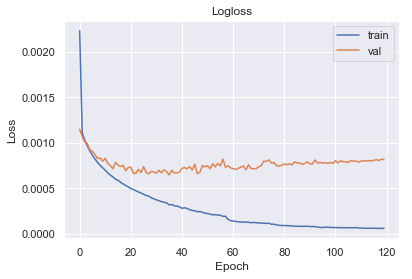

In [11]:
plt.plot(losses['train']['logloss'])
plt.plot(losses['val']['logloss'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Logloss')

Text(0.5,1,'Lwlrap')

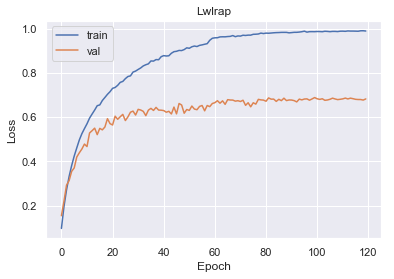

In [12]:
plt.plot(losses['train']['lwlrap'])
plt.plot(losses['val']['lwlrap'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Lwlrap')